In [49]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset

# Load a subset of the ImageNet Images

dataset = load_dataset("frgfm/imagenette", "full_size")
images = dataset["validation"]["image"]

images



Found cached dataset imagenette (/home/codespace/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
100%|██████████| 2/2 [00:00<00:00, 600.73it/s]


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x487>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x177>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=420x320>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=550x444>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x122>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x164>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x524>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=176x150>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x300>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=303x237>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x279>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.Jpeg

In [50]:
# Define the image processor and the pre-trained classifier

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
pretrained_classifier = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


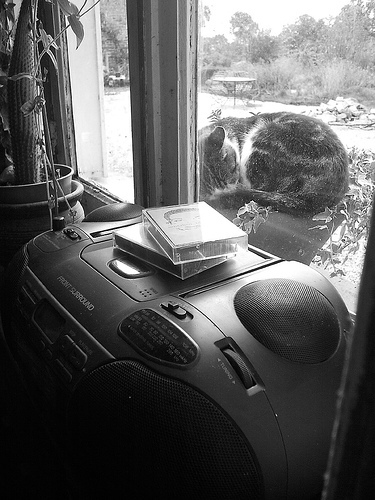

In [72]:
images[50:55]
images[51]

In [67]:
# inputs = image_processor(images, return_tensors="pt")

# image_processor(images[:50], return_tensors="pt")
# image_processor(images[3800:], return_tensors="pt")

# with torch.no_grad():
#     logits = pretrained_classifier(**inputs).logits

# # model predicts one of the 1000 ImageNet classes
# predicted_labels = logits.argmax(-1).item()
# print(model.config.id2label[predicted_label])

ValueError: Unsupported number of image dimensions: 2

In [5]:
from transformers import AutoImageProcessor, ResNetModel
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetModel.from_pretrained("microsoft/resnet-50")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

No config specified, defaulting to: cats-image/image
Found cached dataset cats-image (/home/codespace/.cache/huggingface/datasets/huggingface___cats-image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)
100%|██████████| 1/1 [00:00<00:00, 457.69it/s]
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

[1, 2048, 7, 7]

In [10]:
dataset = load_dataset("frgfm/imagenette", "full_size")

Dataset imagenette downloaded and prepared to /home/codespace/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 516.19it/s]


In [15]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281>,
 'label': 2}

In [46]:
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
image = dataset["train"][0]['image']
images =dataset["train"][:4]['image']
inputs = image_processor(images, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# # model predicts one of the 1000 ImageNet classes
# predicted_label = logits.argmax(-1).item()
# print(model.config.id2label[predicted_label])

In [47]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

In [48]:
inputs['pixel_values'].shape

torch.Size([4, 3, 224, 224])

In [37]:
logits

tensor([[-11.0298, -11.9246,  -9.1829,  ..., -11.1007, -10.2706, -10.2507],
        [-11.5041, -10.9961, -11.0394,  ..., -11.2764, -11.7850,  -9.7115]])

In [40]:
from sklearn.neural_network import MLPClassifier

myMLP = MLPClassifier()
